# CNN方法

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

import os
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model
from tqdm.keras import TqdmCallback
from keras import Input
import itertools
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)

In [2]:
#====================================================
#            Load Dataset(CIFAR10)
#TYPE: airplane、automobile、bird、cat、deer、dog、frog、horse、ship、truck
#====================================================

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
#====================================================
#            Data preprocessing(CIFAR10)
#====================================================
# 数据集分割（训练集90%，验证集10%）
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# 打印数据集大小
print(f"📊 Dataset sizes:")
print(f" - Training set: {X_train.shape[0]} images")
print(f" - Validation set: {X_val.shape[0]} images")
print(f" - Test set: {X_test.shape[0]} images")

# 数据标准化（基于训练集统计）
mean = np.mean(X_train, axis=(0,1,2))
std = np.std(X_train, axis=(0,1,2))

def normalize_data(images):
    """标准化函数"""
    return (images - mean) / (std + 1e-7)

X_train = normalize_data(X_train.astype('float32'))
X_val = normalize_data(X_val.astype('float32'))
X_test = normalize_data(X_test.astype('float32'))

# One-Hot编码
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

# 数据增强配置
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    brightness_range=[0.9,1.1]
)

📊 Dataset sizes:
 - Training set: 45000 images
 - Validation set: 5000 images
 - Test set: 10000 images


In [4]:
# -----------------------------------------------------
# 参数空间设置
# -----------------------------------------------------

learning_rates = [1e-3]
batch_sizes = [64]
dropout_schemes = [
    [0.1, 0.2, 0.3, 0.4],  # 方案2
]


results = []
best_val_acc = 0
best_model = None
best_config = None

In [5]:
# ====================================================
#               CNN Model Architecture 
# ====================================================
def build_model(dropouts):
    model = Sequential()
    model.add(Input(shape=(32, 32, 3)))  # ✅ 显式添加输入层
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropouts[0]))

    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropouts[1]))

    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropouts[2]))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropouts[3]))
    model.add(Dense(10, activation='softmax'))
    return model


In [6]:
# ----------------------------------------
# 在循环外部，初始化一个字典来存储所有 history
# ----------------------------------------
all_histories = {}

# ====================================================
#               Model Training
# ====================================================


for lr, bs, dropouts in itertools.product(learning_rates, batch_sizes, dropout_schemes):
    config_name = f"learning_rates={lr}_batch_sizes={bs}_dropout={dropouts}"
    print(f"\n🚀 Training: {config_name}")
    model = build_model(dropouts)
    model.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6),
        TqdmCallback(verbose=1)
    ]

    history = model.fit(
        train_datagen.flow(X_train, y_train, batch_size=bs),
        epochs=20,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=0
    )
     # 把 history 对象保存下来
    all_histories[config_name] = history

    train_acc = history.history['accuracy'][-1]
    train_loss = history.history['loss'][-1]
    val_acc = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]

    # 打印训练结果
    print(f"✅ Finished: Train Acc = {train_acc:.4f}, Train Loss = {train_loss:.4f}, "
          f"Val Acc = {val_acc:.4f}, Val Loss = {val_loss:.4f}")


    # 保存最好模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model
        best_config = (lr, bs, dropouts)
        model.save("best_cifar_cnn_model_0504.h5")

    results.append({
        'Learning Rate': lr,
        'Batch Size': bs,
        'Dropouts': dropouts,
        'Train Accuracy': round(train_acc, 4),
        'Val Accuracy': round(val_acc, 4),
    })



🚀 Training: learning_rates=0.001_batch_sizes=64_dropout=[0.1, 0.2, 0.3, 0.4]


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


✅ Finished: Train Acc = 0.8169, Train Loss = 0.5496, Val Acc = 0.8364, Val Loss = 0.4838


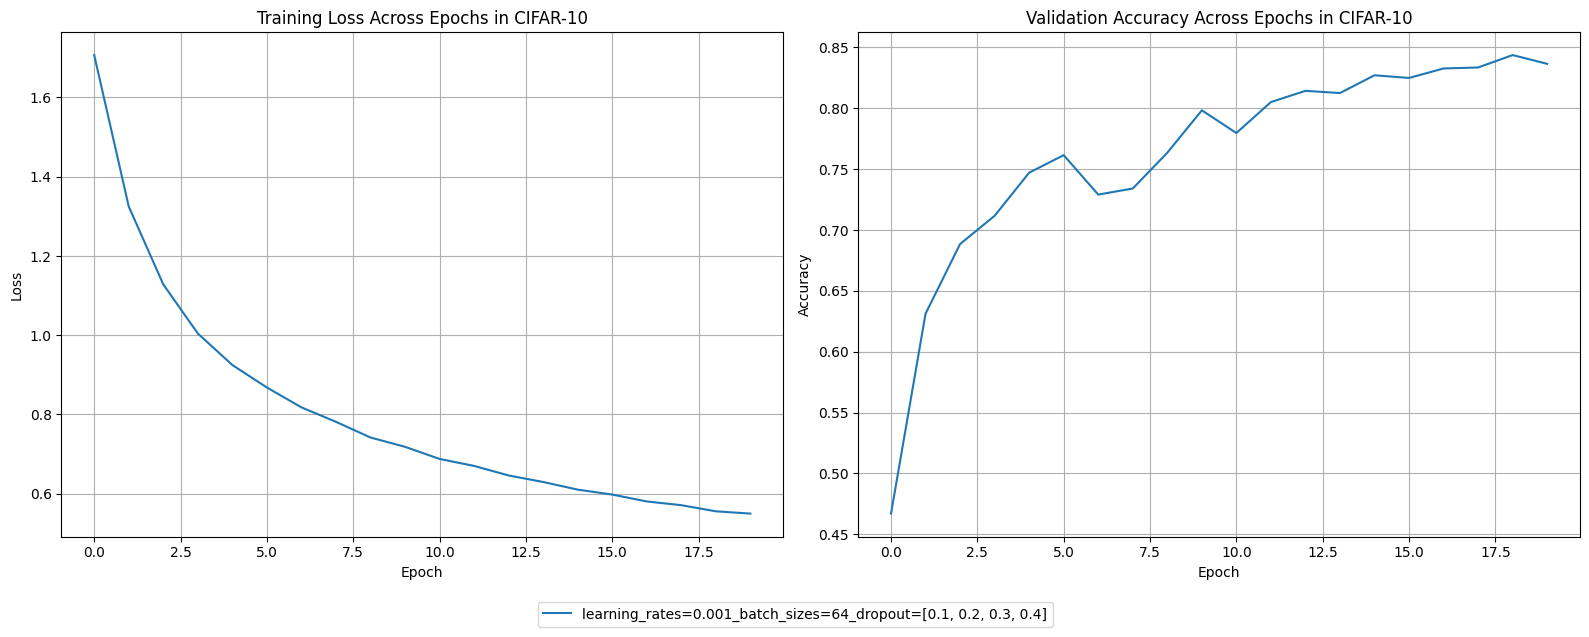

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Create a list to hold the legend handles and labels
handles, labels = [], []

# Left plot: Training Loss
for name, hist in all_histories.items():
    line, = axes[0].plot(hist.history['loss'], label=name)
    handles.append(line)  # Save the line handle
    labels.append(name)   # Save the label for the legend
axes[0].set_title('Training Loss Across Epochs in CIFAR-10')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

# Right plot: Validation Accuracy
for name, hist in all_histories.items():
    axes[1].plot(hist.history['val_accuracy'], label=name)
axes[1].set_title('Validation Accuracy Across Epochs in CIFAR-10')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)

# Now add a single legend for both subplots
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0))

# Apply tight_layout for the whole figure
fig.tight_layout()

plt.show()



----------- Basic Evaluation -----------
Test Accuracy: 0.8365
Test Loss: 0.4879

---------- Aggregate Metrics -----------
Macro F1:       0.8333
Macro Precision:0.8384
Macro Recall:   0.8365
Weighted F1:       0.8333
Weighted Precision:0.8384
Weighted Recall:   0.8365

-------- Classification Report ---------
              precision    recall  f1-score   support

    airplane     0.8640    0.8070    0.8345      1000
  automobile     0.9323    0.9230    0.9276      1000
        bird     0.8658    0.7030    0.7759      1000
         cat     0.8051    0.5990    0.6869      1000
        deer     0.7825    0.8600    0.8194      1000
         dog     0.7887    0.7540    0.7710      1000
        frog     0.7837    0.9420    0.8556      1000
       horse     0.8452    0.9120    0.8773      1000
        ship     0.9090    0.9090    0.9090      1000
       truck     0.8074    0.9560    0.8755      1000

    accuracy                         0.8365     10000
   macro avg     0.8384    0.8365    

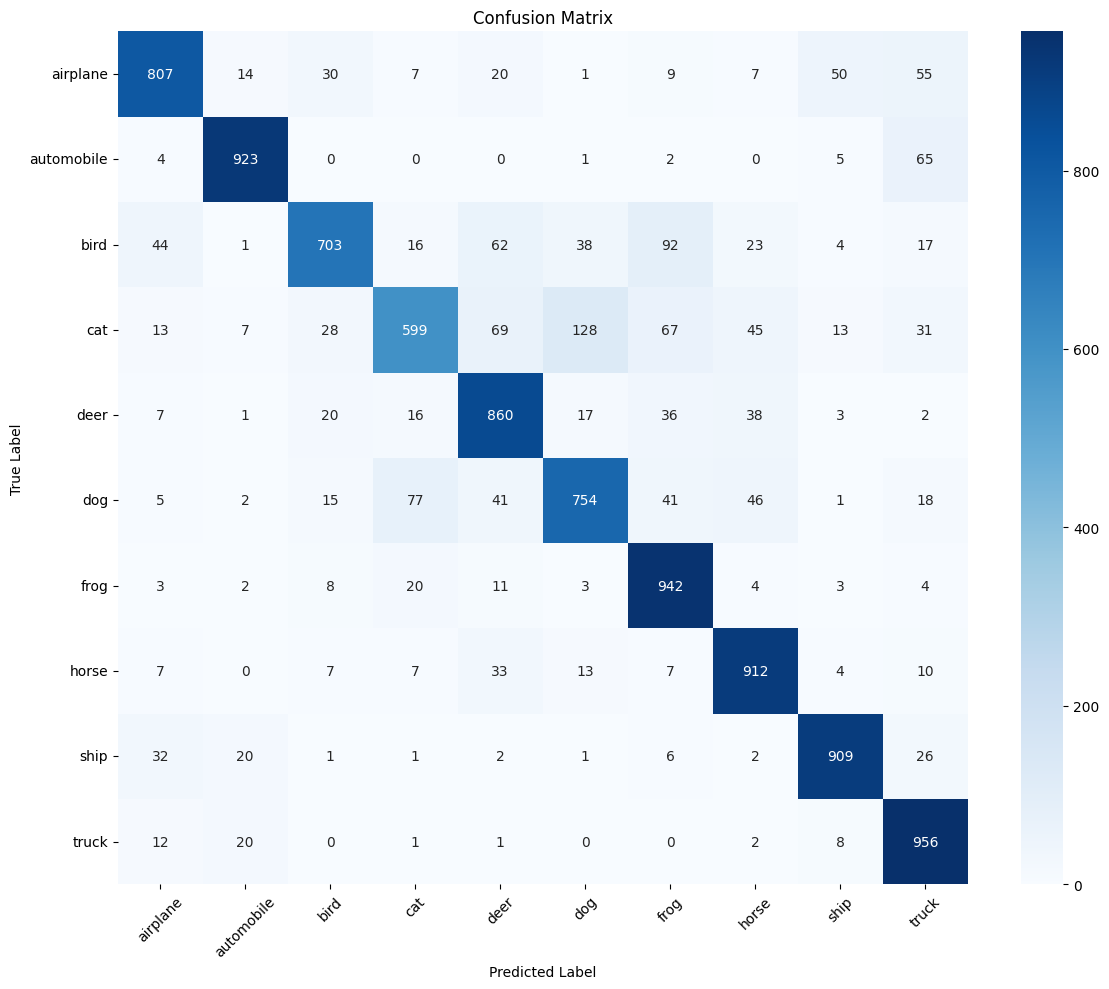

In [8]:

# ====================================================
#               Enhanced Model Evaluation
# ====================================================
def enhanced_model_evaluation(model, X_test, y_test, class_names):
    # 基础评估
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f'\n{" Basic Evaluation ":-^40}')
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Loss: {test_loss:.4f}')
    
    # 获取预测结果
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # 如果 y_test 是 one-hot 格式，需要转换为整数标签
    if y_test.shape[-1] == len(class_names):  # 假设最后一维长度和类别数一致
        y_test_classes = np.argmax(y_test, axis=1)
    else:
        y_test_classes = y_test  # 已是整数标签

    # 各指标计算
    weighted_f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    macro_f1 = f1_score(y_test_classes, y_pred_classes, average='macro')
    
    weighted_precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    macro_precision = precision_score(y_test_classes, y_pred_classes, average='macro')
    
    weighted_recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    macro_recall = recall_score(y_test_classes, y_pred_classes, average='macro')

    print(f'\n{" Aggregate Metrics ":-^40}')
    print(f'Macro F1:       {macro_f1:.4f}')
    print(f'Macro Precision:{macro_precision:.4f}')
    print(f'Macro Recall:   {macro_recall:.4f}')
    
    print(f'Weighted F1:       {weighted_f1:.4f}')
    print(f'Weighted Precision:{weighted_precision:.4f}')
    print(f'Weighted Recall:   {weighted_recall:.4f}')
    
    # 多分类评估指标
    print(f'\n{" Classification Report ":-^40}')
    print(classification_report(y_test_classes, y_pred_classes, target_names=class_names, digits=4))

    # 混淆矩阵可视化
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# 执行增强评估
model = load_model("best_cifar_cnn_model_0504.h5")
enhanced_model_evaluation(model, X_test, y_test, class_names)
    

In [9]:
def draw_bounding_box(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY_INV)  # 可以尝试其他阈值策略
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # 取最大轮廓作为物体（你也可以遍历所有轮廓）
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        image_with_box = image.copy()
        cv2.rectangle(image_with_box, (x, y), (x+w, y+h), (0,255,0), 2)
        return image_with_box, (x, y, w, h)
    else:
        return image, None

In [10]:
def predict_local_image(image_path, model, class_names, mean, std):
    """
    参数说明：
    - image_path: 本地图像路径
    - model: 训练好的Keras模型
    - class_names: 类别名称列表
    - mean: 训练集的均值
    - std: 训练集的标准差
    """
    try:
        # 创建1x2的画布布局
        plt.figure(figsize=(16, 6))  # 宽度16英寸，高度6英寸

        # ====================== 左侧：原始图像 ======================
        plt.subplot(1, 2, 1)  # 1行2列的第1个位置
        
        # 读取并显示原始图像
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"无法读取文件：{image_path}")
        
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Original Image", fontsize=14, pad=20)
        plt.axis('off')

        # ====================== 右侧：预测结果 ======================
        plt.subplot(1, 2, 2)  # 1行2列的第2个位置
        
        # 图像预处理（保持与训练一致）
        processed_image = cv2.resize(image, (32, 32))
        processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
        processed_image = (processed_image.astype('float32') - mean) / (std + 1e-7)
        
        # 模型预测
        prediction = model.predict(np.expand_dims(processed_image, axis=0))
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)

        # 绘制概率分布
        bar_colors = ['#1f77b4'] * len(class_names)  # 统一使用Matplotlib默认蓝色
        bar_colors[predicted_class] = '#d62728'      # 预测类别使用醒目红色
        
        bars = plt.barh(class_names, prediction[0], color=bar_colors, alpha=0.8)
        plt.title(
            f"Prediction Result\n{class_names[predicted_class]} ({confidence:.2%})",
            fontsize=14,
            pad=20
        )
        plt.xlabel("Confidence Score", fontsize=12)
        plt.gca().invert_yaxis()  # 反转y轴使顶部显示第一个类别
        
        # 添加数值标签
        for bar in bars:
            width = bar.get_width()
            plt.text(
                width + 0.02,  # x位置：条形宽度右侧偏移2%
                bar.get_y() + bar.get_height()/2,  # y位置：条形中心
                f"{width:.2%}",
                va='center',
                ha='left',
                fontsize=10
            )

        plt.grid(axis='x', linestyle='--', alpha=0.7)  # 添加横向网格线
        plt.tight_layout()  # 自动调整子图间距
        
        plt.show()
        
        return class_names[predicted_class], confidence

    except Exception as e:
        print(f"预测出错：{str(e)}")
        return None, None

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


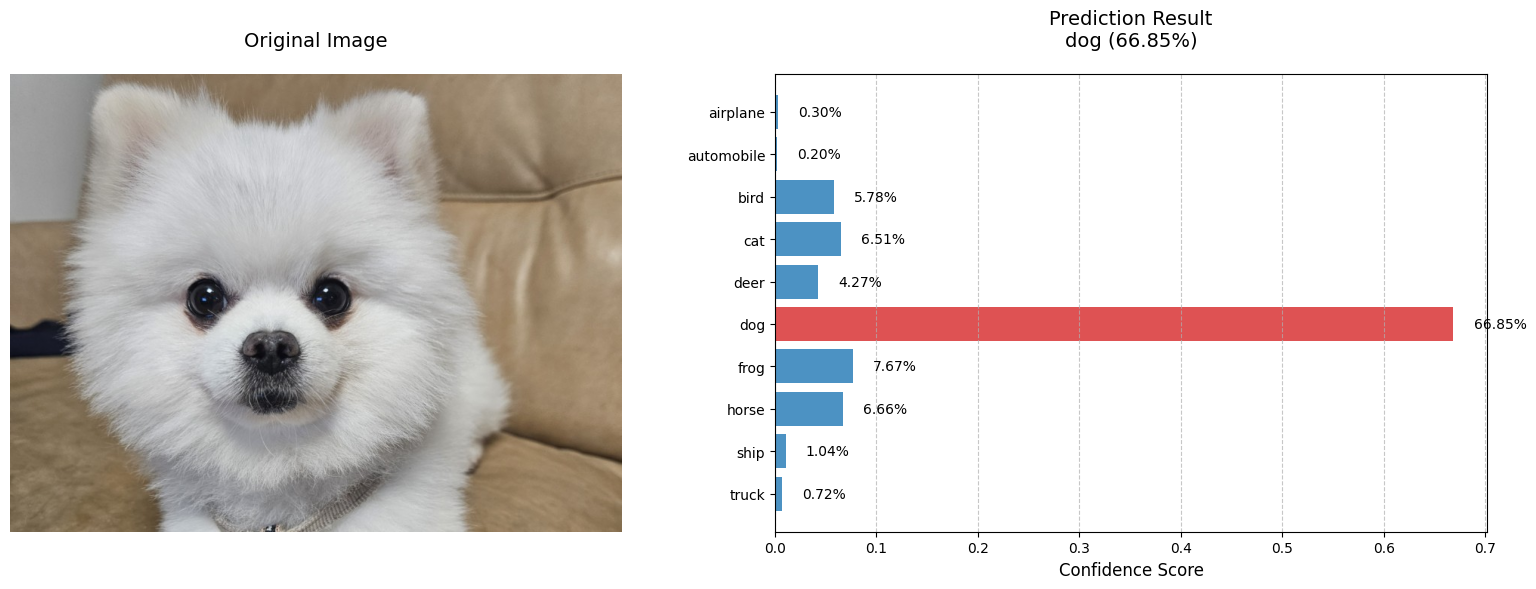


预测结果：dog（置信度：66.85%）


In [11]:
# ====================================================
#               Test Example
# ====================================================
# 定义类别名称（需与训练时一致）
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# 调用预测函数
img_path = "dataset/testImg/dog.jpeg"  # 替换为实际路径
pred_class, confidence = predict_local_image(
    image_path=img_path,
    model=model,                   # 训练好的模型
    class_names=class_names,
    mean=mean,                     # 来自训练集的均值
    std=std                        # 来自训练集的标准差
)

if pred_class is not None:
    print(f"\n预测结果：{pred_class}（置信度：{confidence:.2%}）")